In [1]:
import pandas as pd
import numpy as np
import requests
from pandas.tseries.offsets import BDay
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.initializers import Orthogonal
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from numpy.polynomial.polynomial import Polynomial
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define the API key and base URL
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'

# Define the currency pairs and years
currency_pairs = ["USDEUR", "USDCAD", "USDAUD", "USDCHF", "USDGBP"]
years = range(2022, 2024)
num_of_outliers_per_year = 15

In [3]:
def calculate_daily_return(df):
    # Use pct_change() to calculate the percentage change in 'c' (close prices)
    df['daily_return'] = df['c'].pct_change()
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=num_of_outliers_per_year):
    return df.nlargest(n, 'abs_daily_return')

# Initialize DataFrames
full_data = pd.DataFrame()
outliers_data = pd.DataFrame()

# Loop over each currency pair and year
for pair in currency_pairs:
    for year in years:
        # Format the API endpoint
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        url = f"https://api.polygon.io/v2/aggs/ticker/C:{pair}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"

        # Make the API request
        response = requests.get(url)
        data = response.json()

        # Check if the request was successful
        if response.status_code == 200 and 'results' in data:
            # Load data into a DataFrame
            df = pd.DataFrame(data['results'])
            # Convert timestamps
            df['date'] = pd.to_datetime(df['t'], unit='ms')
            df.drop(columns=['t'], inplace=True)

            df = df[df['date'].dt.weekday < 5]
            # Calculating returns
            df = calculate_daily_return(df)

            # Append the data to the full_data DataFrame for the current currency pair
            df['year'] = year
            df['day'] = df['date'].dt.day_name()
            df['pair'] = pair  # Added pair name to track different currencies

            # Find the top 15 outliers based on absolute values of the daily return value
            top_outliers = get_top_outliers(df, n=num_of_outliers_per_year)
            outlier_dates = top_outliers['date']

            # Create a new column 'is_outlier' in the full_data DataFrame
            df['is_outlier'] = df['date'].isin(outlier_dates).astype(int)
            full_data = pd.concat([full_data, df], ignore_index=True)

            # Append outliers to the outliers_data DataFrame for the current currency pair
            top_outliers['year'] = year
            outliers_data = pd.concat([outliers_data, top_outliers], ignore_index=True)

sorted_full_data = full_data.sort_values(by="date")
sorted_outliers_data = outliers_data.sort_values(by="date")

In [4]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - BDay(14), # To predict X days, keep this as X-1 (as 1 day of outlier will be considered in LSTM input)
    "end_date": sorted_outliers_data['date'] + BDay(15),
    "outlier_date": sorted_outliers_data['date'],
    "outlier_price": sorted_outliers_data['c'],
    "daily_return": sorted_outliers_data['daily_return'],
    "pair": sorted_outliers_data['pair']
})

date_ranges.reset_index(drop=True, inplace=True)

date_ranges

,start_date,end_date,outlier_date,outlier_price,daily_return,pair
0,2022-02-17,2022-03-30,2022-03-09,0.903020,-0.015868,USDEUR
1,2022-02-22,2022-04-04,2022-03-14,1.388696,0.020608,USDAUD
2,2022-04-05,2022-05-16,2022-04-25,1.393100,0.026561,USDAUD
3,2022-04-14,2022-05-25,2022-05-04,1.379025,-0.020768,USDAUD
4,2022-04-15,2022-05-26,2022-05-05,0.808850,0.020541,USDGBP
...,...,...,...,...,...,...
145,2023-10-25,2023-12-05,2023-11-14,0.889100,-0.013427,USDCHF
146,2023-11-23,2024-01-03,2023-12-13,1.500218,-0.015152,USDAUD
147,2023-11-24,2024-01-04,2023-12-14,0.782990,-0.011688,USDGBP
148,2023-12-07,2024-01-17,2023-12-27,0.842500,-0.013142,USDCHF


In [5]:
def fetch_daily_data(pair, start_date, end_date, api_key):
	formatted_start_date = start_date.strftime('%Y-%m-%d')
	formatted_end_date = end_date.strftime('%Y-%m-%d')

	url = f"https://api.polygon.io/v2/aggs/ticker/C:{pair}/range/1/day/{formatted_start_date}/{formatted_end_date}?adjusted=true&sort=asc&apiKey={api_key}"
	response = requests.get(url)

	if response.status_code != 200:
		print(f"Failed to fetch data: {response.status_code} - {response.text}")
		return None

	response_data = response.json()

	if 'results' not in response_data:
		print(f"No 'results' in response: {response_data}")
		return None

	df = pd.DataFrame(response_data['results'])
	df['date'] = pd.to_datetime(df['t'], unit='ms')
	df.drop(columns=['t'], inplace=True)

	daily_data = calculate_daily_return(df)
	daily_data.set_index('date', inplace=True)

	return daily_data

def fetch_and_process_daily_data(pair, start_date, end_date, api_key):
	daily_data = fetch_daily_data(pair, start_date, end_date, api_key)

	if daily_data is None:
		print("No data fetched")
		return None

	daily_data.reset_index(inplace=True)
	return daily_data

def process_data_and_train_model(daily_data):
	"""Processes daily data, trains an LSTM model, and returns the model and scaler."""
	# Filter out weekends
	daily_data = daily_data[~daily_data['date'].dt.weekday.isin([5, 6])]

	# Sort data by date
	daily_data.sort_values(by='date', ascending=True, inplace=True)

	# Fill missing values
	daily_data.fillna(method='bfill', inplace=True)
	daily_data.fillna(method='ffill', inplace=True)

	# Split the dataset into train and test sets
	train_set = daily_data.iloc[:15].reset_index(drop=True)
	test_set = daily_data.iloc[15:].reset_index(drop=True)

	# Normalize the data using only the training data
	scaler = MinMaxScaler()
	train_scaled = scaler.fit_transform(train_set[["c"]])

	# Prepare data for LSTM model
	sequence_length = 12
	train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
	validation_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)

	# Within the Sequential model definition:
	model = Sequential([
		LSTM(64, return_sequences=True, input_shape=(sequence_length, 1), kernel_initializer=Orthogonal()),
		LeakyReLU(alpha=0.01),  # Specify LeakyReLU with a small alpha
		Dropout(0.2),
		LSTM(32),  # Last LSTM layer may not return sequences by default
		LeakyReLU(alpha=0.01),  # Specify LeakyReLU with a small alpha
		Dropout(0.2),
		Dense(1)
	])
	model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

	# Early stopping to avoid overfitting
	early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

	# Fit the model with validation data
	history = model.fit(train_generator, epochs=100, verbose=0, validation_data=validation_generator, callbacks=[early_stopping])

	# Prepare the last sequence for forecasting
	last_sequence = train_scaled[-sequence_length:]

	# Forecast the next steps
	forecast_steps = len(test_set)
	predictions_scaled = []
	for _ in range(forecast_steps):
		last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
		next_step_pred = model.predict(last_sequence_reshaped, verbose=0)
		predictions_scaled.append(next_step_pred.ravel()[0])
		last_sequence = np.roll(last_sequence, -1)
		last_sequence[-1] = next_step_pred

	# Inverse transform predictions
	predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

	return predictions_inv, forecast_steps, test_set

def theils_u_statistic(actuals, predictions):
	"""Calculate Theil's U statistic to evaluate forecasting accuracy."""
	actuals = np.array(actuals)
	predictions = np.array(predictions)
	numerator = np.sqrt(np.mean(((actuals - predictions) / actuals) ** 2))
	mean_actuals = np.mean(actuals)
	term_actuals = np.sqrt(np.mean((actuals / mean_actuals) ** 2))
	term_predictions = np.sqrt(np.mean((predictions / mean_actuals) ** 2))
	theils_u = numerator / (term_actuals + term_predictions)
	return theils_u

# Functions to encapsulate trading strategies
def execute_long_strategy(predictions_inv, test_set, stop_loss_percentage):
	exit_idx = np.argmax(predictions_inv)
	entry_idx = np.argmin(predictions_inv[:exit_idx + 1])
	entry_price = predictions_inv[entry_idx][0]
	exit_price = predictions_inv[exit_idx][0]
	entry_date = test_set.iloc[entry_idx]['date']
	exit_date = test_set.iloc[exit_idx]['date']

	# Calculate stop-loss price for a long position
	stop_loss_price = entry_price * (1 - stop_loss_percentage)

	# Check if stop-loss is triggered during the period held
	for i in range(entry_idx, exit_idx + 1):
		current_price = predictions_inv[i][0]
		if current_price <= stop_loss_price:
			exit_price = current_price  # Update exit price to stop-loss price
			exit_date = test_set.iloc[i]['date']
			break  # Exit the loop and trade

	profit = (exit_price - entry_price) * 100 / entry_price
	days_held = exit_idx - entry_idx
	return "Long",entry_price, entry_date, exit_price, exit_date, days_held, profit

def execute_short_strategy(predictions_inv, test_set, stop_loss_percentage):
	entry_idx = np.argmax(predictions_inv)
	exit_idx = np.argmin(predictions_inv[entry_idx:]) + entry_idx
	entry_price = predictions_inv[entry_idx][0]
	exit_price = predictions_inv[exit_idx][0]
	entry_date = test_set.iloc[entry_idx]['date']
	exit_date = test_set.iloc[exit_idx]['date']

	# Calculate stop-loss price for a short position
	stop_loss_price = entry_price * (1 + stop_loss_percentage)

	# Check if stop-loss is triggered during the period held
	for i in range(entry_idx, exit_idx + 1):
		current_price = predictions_inv[i][0]
		if current_price >= stop_loss_price:
			entry_price = current_price  # Update entry price to stop-loss price
			entry_date = test_set.iloc[i]['date']
			break  # Exit the loop and trade

	profit = (entry_price - exit_price) * 100 / entry_price
	days_held = exit_idx - entry_idx
	return "Short",entry_price, exit_price, entry_date, exit_price, exit_date, days_held, profit

In [6]:
# Create an empty list to store the model performance metrics for each outlier
trade_results_list = []

# Define the stop-loss percentage
stop_loss_percentage = 0.01  # 1% stop loss

# Loop through each outlier in date_ranges
for idx, row in date_ranges.iterrows():
	start_date_co = pd.Timestamp(row['start_date'])
	end_date_co = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)
	outlier_date_co = pd.Timestamp(row['outlier_date'])

	# Fetch the currency pair for the current outlier
	pair = row['pair']

	# Fetch and process daily data for the current range
	daily_data = fetch_and_process_daily_data(pair, start_date_co, end_date_co, api_key)

	if daily_data is None:
		print(f"No data fetched for outlier_id: {idx + 1}")
		continue  # Skip to the next iteration if no data

	# LSTM for Predictions
	predictions_inv, forecast_steps, test_set = process_data_and_train_model(daily_data)

	# Actual values for comparison
	actuals = test_set["c"].values[:forecast_steps]

	# Calculate MAPE (Mean Absolute Percentage Error)
	mse = mean_squared_error(actuals, predictions_inv)
	rmse = np.sqrt(mse)
	mape = mean_absolute_percentage_error(actuals, predictions_inv)
	accuracy = np.round(100 - (mape * 100), 2)
	theils_u = theils_u_statistic(actuals, predictions_inv)

	# Using Poly Reg to define Market Trend
	actual_days = np.arange(1, len(actuals) + 1)
	coeffs_actual = np.polyfit(actual_days, actuals, 2)  # Degree 2 polynomial for example
	p_actual = Polynomial(coeffs_actual)
	actual_slope = p_actual.deriv(1)(len(actuals))

	# Determine the actual market trend based on the slope and outlier type
	if row['daily_return'] > 0:  # Positive outlier
		actual_market_trend = "Momentum Continuation" if actual_slope > 0 else "Mean Reversion"
	else:  # Negative outlier
		actual_market_trend = "Momentum Continuation" if actual_slope < 0 else "Mean Reversion"

	# Determine if the outlier is positive or negative
	outlier_return = row['daily_return']
	is_positive_outlier = outlier_return > 0  # Check if the outlier is positive based on its daily return value
	outlier_type = "Positive" if is_positive_outlier else "Negative"  # Define outlier type

	# Using Poly Reg to define Market Trend
	days = np.arange(1, len(predictions_inv) + 1)
	coeffs_pred = np.polyfit(days, predictions_inv.ravel(), 2)
	p_pred = Polynomial(coeffs_pred)
	pred_slope = p_pred.deriv(1)(len(predictions_inv))

	market_trend = ""
	trade_initiated = False
	entry_price = None
	exit_price = None
	entry_date = None
	exit_date = None
	profit = 0
	days_held = 0
	position_type = None

	# Decision-making based on the slope of the polynomial regression at the last day
	if outlier_type == "Positive":
		if pred_slope > 0:
			market_trend = "Momentum Continuation"
			position_type, entry_price, entry_date, exit_price, exit_date, days_held, profit = execute_long_strategy(predictions_inv, test_set, stop_loss_percentage)
		else:
			market_trend = "Mean Reversion"
			position_type, entry_price, entry_date, exit_price, exit_date, days_held, profit = execute_short_strategy(predictions_inv, test_set, stop_loss_percentage)
	else:  # Negative outlier
		if pred_slope < 0:
			market_trend = "Momentum Continuation"
			position_type,entry_price, entry_date, exit_price, exit_date, days_held, profit = execute_short_strategy(predictions_inv, test_set, stop_loss_percentage)
		else:
			market_trend = "Mean Reversion"
			position_type, entry_price, entry_date, exit_price, exit_date, days_held, profit = execute_long_strategy(predictions_inv, test_set, stop_loss_percentage)


	# Append trade results for every outlier, even if no trade was initiated
	trade_results_list.append({
	'Outlier Date': outlier_date_co,
	'Outlier Price': row['outlier_price'],
	'Outlier Type': outlier_type,
	'Actual Market Trend': actual_market_trend,
	'Predicted Market Trend': market_trend,
	'Position Type': position_type,
	'Entry Date': entry_date,
	'Entry Price': entry_price,
	'Exit Date': exit_date,
	'Exit Price': exit_price,
	'Trading Days': days_held,
	'Profit': profit,
	'model_RMSE': rmse,
	'model_accuracy': accuracy,
	'theils_u': theils_u,
	'Pair': row['pair']
})

# Convert the list of dictionaries to a DataFrame
trade_results_df = pd.DataFrame(trade_results_list)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_34244/2915295418.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data.sort_values(by='date', ascending=True, inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_34244/2915295418.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data.fillna(method='bfill', inplace=True)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_34244/2915295418.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data.fillna(method='bfill', i

In [7]:
sorted_trade_results_df = trade_results_df.sort_values(by=['Pair', 'Outlier Date'], ascending=[True, True])
sorted_trade_results_df.reset_index(drop=True, inplace=True)

Model Accuracy: 100.0 %
Model Precision: 100.0 %
Model Recall: 100.0 %
False Positives for Mean Reversion: 0 / 77
False Negatives for Mean Reversion: 0 / 77
False Positives for Momentum Continuation: 0 / 73
False Negatives for Momentum Continuation: 0 / 73
False Negatives Ratio for Mean Reversion: 0.0
False Positives Ratio for Mean Reversion: 0.0
False Negatives Ratio for Momentum Continuation: 0.0
False Positives Ratio for Momentum Continuation: 0.0


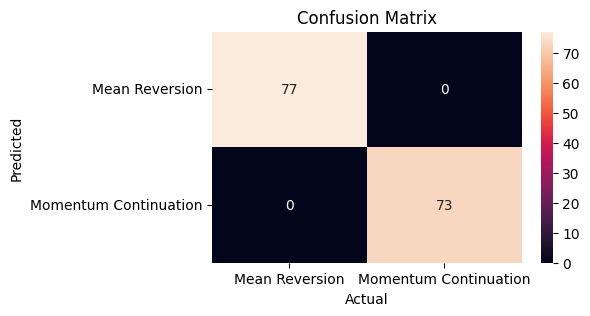

In [8]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Assuming 'Actual Market Trend' and 'Predicted Market Trend' are the columns of interest
# Encode labels
actual_encoded = label_encoder.fit_transform(sorted_trade_results_df['Actual Market Trend'])
predicted_encoded = label_encoder.transform(sorted_trade_results_df['Predicted Market Trend'])

# Evaluate Model based on Accuracy, Precision and Recall
Accuracy = accuracy_score(y_true=actual_encoded, y_pred=predicted_encoded)
Precision = precision_score(y_true=actual_encoded, y_pred=predicted_encoded)
Recall = recall_score(y_true=actual_encoded, y_pred=predicted_encoded)

print('Model Accuracy:', round(Accuracy * 100, 2), '%')
print('Model Precision:', round(Precision * 100, 2), '%')
print('Model Recall:', round(Recall * 100, 2), '%')

# Generate the confusion matrix
cm = confusion_matrix(actual_encoded, predicted_encoded, labels=[0,1])

# FP for Mean Reversion
FP_Mean_Reversion = cm[0][1]
# FN for Mean Reversion
FN_Mean_Reversion = cm[1][0]
# FP for Momentum Continuation
FP_Momentum_Continuation = cm[1][0]
# FN for Momentum Continuation
FN_Momentum_Continuation = cm[0][1]

# Total counts for each class
total_mean_reversion = cm[0, 0] + cm[0, 1]  # TN + FP for 'Mean Reversion'
total_momentum_continuation = cm[1, 1] + cm[1, 0]  # TP + FN for 'Momentum Continuation'

# Calculating ratios
FN_ratio_Mean_Reversion = FN_Mean_Reversion / total_mean_reversion
FP_ratio_Mean_Reversion = FP_Mean_Reversion / total_mean_reversion
FN_ratio_Momentum_Continuation = FN_Momentum_Continuation / total_momentum_continuation
FP_ratio_Momentum_Continuation = FP_Momentum_Continuation / total_momentum_continuation

print(f"False Positives for Mean Reversion: {FP_Mean_Reversion} / {total_mean_reversion}")
print(f"False Negatives for Mean Reversion: {FN_Mean_Reversion} / {total_mean_reversion}")
print(f"False Positives for Momentum Continuation: {FP_Momentum_Continuation} / {total_momentum_continuation}")
print(f"False Negatives for Momentum Continuation: {FN_Momentum_Continuation} / {total_momentum_continuation}")

# Output the results
print("False Negatives Ratio for Mean Reversion:", round(FN_ratio_Mean_Reversion, 2))
print("False Positives Ratio for Mean Reversion:", round(FP_ratio_Mean_Reversion, 2))
print("False Negatives Ratio for Momentum Continuation:", round(FN_ratio_Momentum_Continuation, 2))
print("False Positives Ratio for Momentum Continuation:", round(FP_ratio_Momentum_Continuation, 2))

# Plotting the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Group by 'Pair' and find the min and max profit for each pair
profit_stats = sorted_trade_results_df.groupby('Pair')['Profit'].agg(['min', 'max']).reset_index()

# Display the results
profit_stats

,Pair,min,max
0,USDAUD,0.0,3.069483
1,USDCAD,0.0,0.571997
2,USDCHF,0.0,3.225926
3,USDEUR,0.0,2.681453
4,USDGBP,0.0,0.409768


In [10]:
min_rmse = round(sorted_trade_results_df["model_RMSE"].min(), 4)
max_rmse = round(sorted_trade_results_df["model_RMSE"].max(), 4)

print('Minimum RMSE:', min_rmse)
print('Maximum RMSE:', max_rmse)

Minimum RMSE: 0.0038
Maximum RMSE: 0.0815


In [11]:
min_accuracy = round(sorted_trade_results_df["model_accuracy"].min(), 4)
max_accuracy = round(sorted_trade_results_df["model_accuracy"].max(), 4)

print('Minimum accuracy:', min_accuracy)
print('Maximum accuracy:', max_accuracy)

Minimum accuracy: 94.0
Maximum accuracy: 99.66


In [12]:
min_theils_u = round(sorted_trade_results_df["theils_u"].min(), 4)
max_theils_u = round(sorted_trade_results_df["theils_u"].max(), 4)

print('Minimum theils_u:', min_theils_u)
print('Maximum theils_u:', max_theils_u)

Minimum theils_u: 0.0021
Maximum theils_u: 0.0311


In [13]:
filtered_df = sorted_trade_results_df[sorted_trade_results_df['Profit'] > 0]
filtered_df.reset_index(drop=True, inplace=True)

filtered_df

,Outlier Date,Outlier Price,Outlier Type,Actual Market Trend,Predicted Market Trend,Position Type,Entry Date,Entry Price,Exit Date,Exit Price,Trading Days,Profit,model_RMSE,model_accuracy,theils_u,Pair
0,2022-04-25,1.393100,Positive,Momentum Continuation,Momentum Continuation,Long,2022-04-26,1.369588,2022-05-17,1.377629,15,0.587113,0.048709,96.83,0.017510,USDAUD
1,2022-05-04,1.379025,Negative,Mean Reversion,Mean Reversion,Long,2022-05-06,1.401169,2022-05-17,1.401288,7,0.008491,0.028312,98.38,0.009906,USDAUD
2,2022-06-13,1.440507,Positive,Momentum Continuation,Momentum Continuation,Long,2022-06-14,1.412608,2022-06-29,1.412984,11,0.026608,0.034812,97.80,0.012105,USDAUD
3,2022-08-02,1.451210,Positive,Momentum Continuation,Momentum Continuation,Long,2022-08-03,1.467254,2022-08-09,1.480541,4,0.905525,0.043652,97.16,0.012834,USDAUD
4,2022-08-29,1.447660,Positive,Momentum Continuation,Momentum Continuation,Long,2022-08-30,1.432141,2022-09-02,1.432401,3,0.018171,0.044593,97.10,0.015272,USDAUD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2023-03-07,0.845460,Positive,Momentum Continuation,Momentum Continuation,Long,2023-03-08,0.835870,2023-03-23,0.835905,11,0.004214,0.016911,98.11,0.010273,USDGBP
80,2023-03-13,0.821830,Negative,Mean Reversion,Mean Reversion,Long,2023-03-14,0.830420,2023-03-29,0.830784,11,0.043891,0.017482,98.05,0.010675,USDGBP
81,2023-07-27,0.781630,Positive,Momentum Continuation,Momentum Continuation,Long,2023-07-31,0.777132,2023-08-14,0.777160,10,0.003628,0.008198,99.03,0.005238,USDGBP
82,2023-08-24,0.794100,Positive,Momentum Continuation,Momentum Continuation,Long,2023-08-29,0.789403,2023-09-15,0.791737,13,0.295568,0.008297,99.12,0.005543,USDGBP


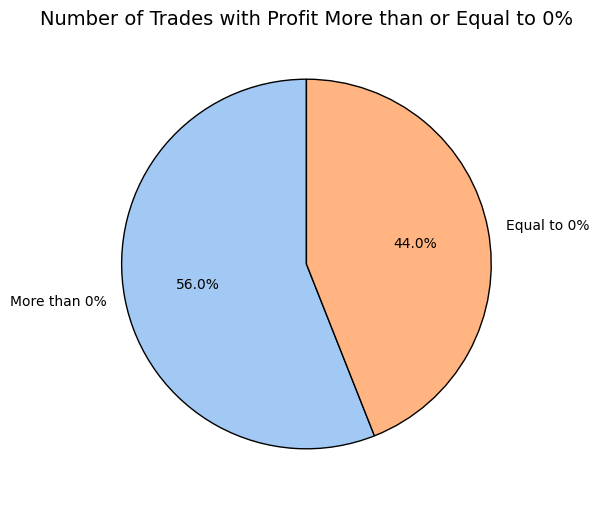

In [14]:
# Plot: Number of trades with profit more than 2% and Equal to 2% (Pie chart)
plt.figure(figsize=(6, 6))

# Create profit categories
trade_results_df['Profit Category'] = trade_results_df['Profit'].apply(lambda x: 'More than 0%' if x > 0 else 'Equal to 0%')
profit_counts = trade_results_df['Profit Category'].value_counts()

# Create pie chart
plt.pie(profit_counts.values, labels=profit_counts.index, autopct='%1.1f%%', colors=sns.color_palette("pastel", len(profit_counts)), startangle=90, wedgeprops={'edgecolor': 'black'})

# Add title
plt.title('Number of Trades with Profit More than or Equal to 0%', fontsize=14)

# Display the pie chart
plt.show()

In [15]:
sorted_trade_results_df.to_csv('multiple_pair_trades_poly.csv')
# filtered_df.to_csv('reliable_multiple_pair_trades.csv')
# filtered_df_profits_rmse_both.to_csv('reliable_multiple_pair_trades_(profits&rmse).csv')